In [1]:
import keras
import pandas as pd
from sklearn.model_selection import train_test_split
import re, string, unicodedata
import nltk
#nltk.download('popular')
from nltk.stem.snowball import SnowballStemmer
#import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer


Using TensorFlow backend.


In [84]:
data = pd.read_csv('google-maps-combinded-dataset.csv',encoding='ISO-8859-1')
data= data[pd.notnull(data['Rationale_Type'])]
data = data.replace("issue ", "issue")
print(len(data))
data.head()

2725


,comment_Text,comment_author,comment_id,comment_upvotes,parent_id,Rationale_Type,Claim_Type,Have_Rationale
1,People still do racial checkbox ads?,PubicLouseInDaHouse,dfadazi,-1,60v5za,claim,neu,NaN
2,What?,Isvara,dfade5q,1,dfadazi,claim,neu,NaN
3,90s power rangers.,PubicLouseInDaHouse,dfadlgi,1,dfade5q,claim,neu,NaN
4,Are there really uses for that?,piponwa,dfa8rlu,-1,60v5za,issue,NaN,NaN
5,https://support.google.com/plus/answer/2998354...,sparr,dfa365t,-1,60v5za,claim,supporting,NaN


In [85]:
def print_plot(index):
    example = data[data.index == index][['comment_Text', 'Rationale_Type']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Rationale_Type:', example[1])


In [86]:
print_plot(60)

> gender equality in any and all professions.

Hahah uh... what?

EDIT: Also I wasn't the one to downvote you above. No clue what that's about.
Rationale_Type: claim


In [87]:
#df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#+_]')
#STOPWORDS = set(stopwords.words('english'))

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    return text

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    #text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    #text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
data['comment_Text'] = data['comment_Text'].apply(clean_text)
#df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')

C:\Users\Ali\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning:

"https://blog.google/products/maps/share-your-trips-and-real-time-location-google-maps/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.

C:\Users\Ali\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning:

"http://www.transphone.net/images/whatsapp-transfer/whatsapp-share-location.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.

C:\Users\Ali\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning:

"http://i.imgur.com/646xV.gif" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.

C:\User

In [88]:
print_plot(60)

  gender equality in any and all professionshahah uh whatedit also i wasnt the one to downvote you above no clue what thats about
Rationale_Type: claim


In [89]:
print(data.Rationale_Type.value_counts())
user_comments= data.comment_Text
rationale_type=data.Rationale_Type
rationale_type_name= data.Rationale_Type.unique()
print(rationale_type_name)

claim      1836
feature     613
issue       276
Name: Rationale_Type, dtype: int64
['claim' 'issue' 'feature']


In [90]:
# load nltk's SnowballStemmer as variabled 'stemmer'
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for user_comments in nltk.sent_tokenize(text) for word in nltk.word_tokenize(user_comments)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    lemmas = []
    for token in tokens:
        lemma = lemmatizer.lemmatize(token, pos='v')
        lemmas.append(lemma)
    return lemmas

In [91]:
totalvocab_stemmed = []
for i in user_comments:
    allwords_stemmed = tokenize_and_stem(i) # for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) 
#print(totalvocab_stemmed)
    

In [92]:
X_train, X_test, Y_train, Y_test = train_test_split(user_comments,rationale_type, test_size = 0.20, random_state = 42)
print(len(X_train))
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

2180
545
2180
545


In [93]:
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer

vocab_size= 10000
tokenizer= Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train_matrix_tfidf= tokenizer.texts_to_matrix(X_train,mode='tfidf')
X_test_matrix_tfidf= tokenizer.texts_to_matrix(X_test, mode='tfidf')

encoder= LabelBinarizer()
encoder.fit(Y_train)
Y_train_matrix_tfidf= encoder.transform(Y_train)
Y_test_matrix_tfidf= encoder.transform(Y_test)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [94]:
X_train_matrix_tfidf.shape, Y_train_matrix_tfidf.shape, X_test_matrix_tfidf.shape

((2180, 10000), (2180, 3), (545, 10000))

In [95]:
#Let us try some sampling technique to remove class imbalance
from imblearn.over_sampling import SMOTE
#Over-sampling: SMOTE
#SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, 
#based on those that already exist. It works randomly picking a point from the minority class and computing 
#the k-nearest neighbors for this point.The synthetic points are added between the chosen point and its neighbors.
#We'll use ratio='minority' to resample the minority class.
smote = SMOTE('minority')

X_sm_tfidf, y_sm_tfidf = smote.fit_sample(X_train_matrix_tfidf, Y_train_matrix_tfidf)
print(X_sm_tfidf.shape, y_sm_tfidf.shape)

(3415, 10000) (3415, 3)


In [96]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
MAX_SEQUENCE_LENGTH = 500
#print(vocab_size)
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
model. summary()
print(model.metrics_names)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 512)               5120512   
_________________________________________________________________
activation_13 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 1539      
_________________________________________________________________
activation_14 (Activation)   (None, 3)                 0         
Total params: 5,122,051
Trainable params: 5,122,051
Non-trainable params: 0
_________________________________________________________________
['loss', 'acc']


In [97]:

batch_size= 12
epochs= 5
history= model.fit(X_sm_tfidf,y_sm_tfidf, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score= model.evaluate(X_test_matrix_tfidf, Y_test_matrix_tfidf, batch_size=batch_size, verbose=1)
print("Test Loss: {}". format(score[0]))
print("Test Accuracy: {}". format(score[1]))

Train on 3073 samples, validate on 342 samples
Epoch 1/5
3073/3073 [==============================] - 15s 5ms/step - loss: 0.6731 - acc: 0.7520 - val_loss: 0.1381 - val_acc: 0.9883
Epoch 2/5
3073/3073 [==============================] - 13s 4ms/step - loss: 0.1827 - acc: 0.9437 - val_loss: 0.0227 - val_acc: 1.0000
Epoch 3/5
3073/3073 [==============================] - 13s 4ms/step - loss: 0.0624 - acc: 0.9831 - val_loss: 0.0142 - val_acc: 1.0000
Epoch 4/5
3073/3073 [==============================] - 13s 4ms/step - loss: 0.0254 - acc: 0.9961 - val_loss: 0.0081 - val_acc: 1.0000
Epoch 5/5
545/545 [==============================] - 0s 295us/step
Test Loss: 1.7199846071934481
Test Accuracy: 0.67155963816774


In [99]:
from sklearn.metrics import classification_report
import numpy as np
pred = model.predict(X_test_matrix_tfidf, batch_size=12, verbose=1)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(Y_test_matrix_tfidf, axis=1), predicted)
print(report)



545/545 [==============================] - 0s 270us/step
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       370
           1       0.52      0.45      0.48       130
           2       0.19      0.18      0.18        45

   micro avg       0.67      0.67      0.67       545
   macro avg       0.49      0.48      0.48       545
weighted avg       0.66      0.67      0.67       545



In [100]:
import plotly.graph_objs as go
import plotly.plotly as py
#import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')

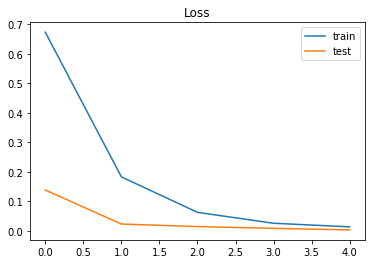

In [101]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

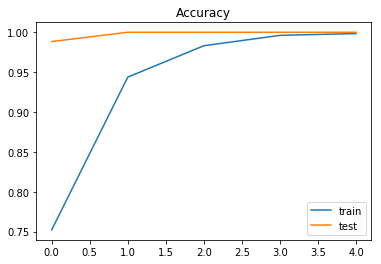

In [102]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [110]:
#using mode=binary
X_train_binary, X_test_binary, Y_train_binary, Y_test_binary = train_test_split(user_comments,rationale_type, test_size = 0.20, random_state = 42)
vocab_size= 10000
tokenizer= Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train_binary)
X_train_matrix_binary= tokenizer.texts_to_matrix(X_train_binary,mode='binary')
X_test_matrix_binary= tokenizer.texts_to_matrix(X_test_binary, mode='binary')

encoder= LabelBinarizer()
encoder.fit(Y_train)
Y_train_matrix_binary= encoder.transform(Y_train_binary)
Y_test_matrix_binary= encoder.transform(Y_test_binary)


LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [111]:
#using mode=binary
from imblearn.over_sampling import SMOTE
smote = SMOTE('minority')
X_sm_binary, y_sm_binary = smote.fit_sample(X_train_matrix_binary, Y_train_matrix_binary)
print(X_sm_binary.shape, y_sm_binary.shape)

(3415, 10000) (3415, 3)


In [112]:
#continue binary 
MAX_SEQUENCE_LENGTH = 500
#print(vocab_size)
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
model. summary()
print(model.metrics_names)

batch_size= 12
epochs= 5
history= model.fit(X_sm_binary,y_sm_binary, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score= model.evaluate(X_test_matrix_binary, Y_test_matrix_binary, batch_size=batch_size, verbose=1)
print("Test Loss: {}". format(score[0]))
print("Test Accuracy: {}". format(score[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               5120512   
_________________________________________________________________
activation_17 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 1539      
_________________________________________________________________
activation_18 (Activation)   (None, 3)                 0         
Total params: 5,122,051
Trainable params: 5,122,051
Non-trainable params: 0
_________________________________________________________________
['loss', 'acc']
Train on 3073 samples, validate on 342 samples
Epoch 1/5
3073/3073 [==============================] - 15s 5ms/step -

In [113]:
pred = model.predict(X_test_matrix_binary, batch_size=12, verbose=1)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(Y_test_matrix_binary, axis=1), predicted)
print(report)


545/545 [==============================] - 0s 838us/step
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       370
           1       0.54      0.55      0.55       130
           2       0.23      0.24      0.24        45

   micro avg       0.68      0.68      0.68       545
   macro avg       0.52      0.53      0.53       545
weighted avg       0.69      0.68      0.69       545



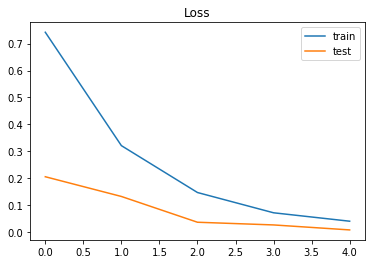

In [114]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

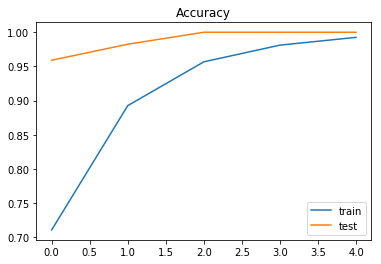

In [116]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [158]:
#using mode=count
X_train_count, X_test_count, Y_train_count, Y_test_count = train_test_split(user_comments,rationale_type, test_size = 0.20, random_state = 42)
vocab_size= 10000
tokenizer= Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train_count)
X_train_matrix_count= tokenizer.texts_to_matrix(X_train_count,mode='count')
X_test_matrix_count= tokenizer.texts_to_matrix(X_test_count, mode='count')

encoder= LabelBinarizer()
encoder.fit(Y_train)
Y_train_matrix_count= encoder.transform(Y_train_count)
Y_test_matrix_count= encoder.transform(Y_test_count)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [159]:
#using mode=binary
from imblearn.over_sampling import SMOTE
smote = SMOTE('minority')
X_sm_count, y_sm_count = smote.fit_sample(X_train_matrix_count, Y_train_matrix_count)
print(X_sm_count.shape, y_sm_count.shape)

(3415, 10000) (3415, 3)


In [119]:
#continue count 
MAX_SEQUENCE_LENGTH = 500
#print(vocab_size)
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
model. summary()
print(model.metrics_names)

batch_size= 12
epochs= 5
history= model.fit(X_sm_count,y_sm_count, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)
score= model.evaluate(X_test_matrix, Y_test_matrix, batch_size=batch_size, verbose=1)
print("Test Loss: {}". format(score[0]))
print("Test Accuracy: {}". format(score[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 512)               5120512   
_________________________________________________________________
activation_19 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 1539      
_________________________________________________________________
activation_20 (Activation)   (None, 3)                 0         
Total params: 5,122,051
Trainable params: 5,122,051
Non-trainable params: 0
_________________________________________________________________
['loss', 'acc']
Train on 3073 samples, validate on 342 samples
Epoch 1/5
3073/3073 [==============================] - 15s 5ms/step -

In [120]:
pred = model.predict(X_test_matrix_count, batch_size=12, verbose=1)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(Y_test_matrix_count, axis=1), predicted)
print(report)


545/545 [==============================] - 1s 940us/step
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       370
           1       0.55      0.48      0.51       130
           2       0.27      0.24      0.26        45

   micro avg       0.69      0.69      0.69       545
   macro avg       0.53      0.52      0.52       545
weighted avg       0.68      0.69      0.69       545



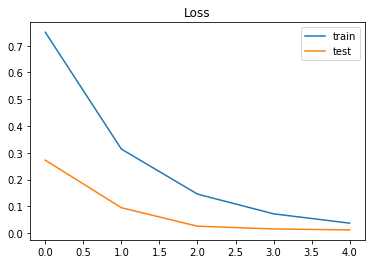

In [121]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

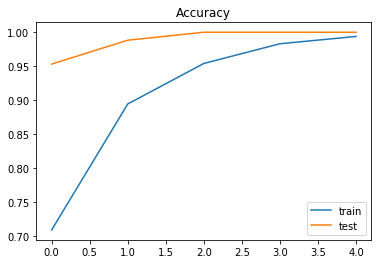

In [122]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

(545, 10000)
Actual label:claim
Predicted label: claim
Actual label:claim
Predicted label: claim
Actual label:claim
Predicted label: claim
Actual label:feature
Predicted label: feature
Actual label:claim
Predicted label: feature
Actual label:issue
Predicted label: issue
Actual label:claim
Predicted label: issue
Actual label:feature
Predicted label: issue
Actual label:issue
Predicted label: claim
Actual label:claim
Predicted label: claim
Normalized confusion matrix


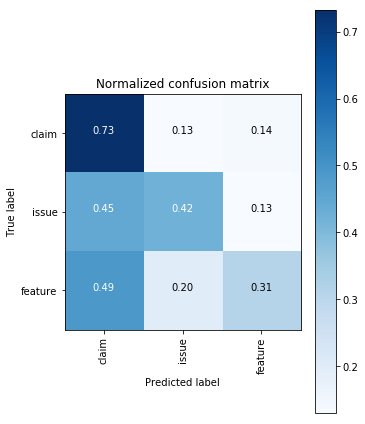

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


print(X_test_matrix.shape)
text_labels = encoder.classes_

for i in range(10):
    prediction = model.predict(np.array([X_test_matrix[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    #print(test_files_names.iloc[i])
    print('Actual label:' + Y_test.iloc[i])
    print("Predicted label: " + predicted_label)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(X_test_matrix);
cnf_matrix = confusion_matrix(np.argmax(Y_test_matrix, axis=1), np.argmax(y_pred, axis=1))

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(5, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(rationale_type_name), normalize=True,
                      title='Normalized confusion matrix')

fig.savefig("txt_classification-smote" + str(12) + ".png", pad_inches=5.0)

In [124]:
prediction = model.predict(X_test_matrix)

In [125]:
predictions = np.argmax(prediction, axis = 1)


In [126]:
predictions

array([0, 0, 0, 1, 1, 2, 2, 2, 0, 0, 1, 2, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0,
       2, 0, 1, 1, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 2, 0, 0, 1, 0, 0,
       1, 0, 2, 0, 1, 0, 2, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 1, 2, 0, 0, 0, 0, 0, 2, 0, 1, 1,
       0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0,
       0, 2, 0, 1, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 2, 0,
       1, 0, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 2, 1, 1, 0, 1,
       0, 1, 2, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0,

In [127]:
y_test_labels = np.argmax(Y_test_matrix, axis =1)


In [128]:
y_test_labels

array([0, 0, 0, 1, 0, 2, 0, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 1, 0, 2, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 2, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,

In [129]:
y_train_labels = np.argmax(Y_train_matrix, axis =1)
y_train_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [130]:
#The Kappa score tell you how much better, or worse, your classifier is than what would be expected by random chance. 
#If you were to randomly assign cases to classes (i.e. a kind of terribly uninformed classifier), you'd get some correct simply by chance. 
#Therefore, you will always find that the Kappa value is lower than the overall accuracy. 
#The Kappa index is however considered to be a more conservative measure than the overall classification accuracy. 
#Your KIA value is telling you essentially that your classifier is about 66% better than a random assignment of cases to the various classes. That's not bad!
#A kappa value of 1 represents perfect agreement, while a value of 0 represents no agreement.

from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test_labels, predictions)

In [131]:
cohen_score

0.24968939928142098

In [132]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test_labels, predictions)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.77207977 0.49107143 0.17073171]
recall: [0.73243243 0.42307692 0.31111111]
fscore: [0.7517337  0.45454545 0.22047244]
support: [370 130  45]


In [133]:

from sklearn.metrics import confusion_matrix
import numpy as np


cm = confusion_matrix(y_test_labels, predictions)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

print(recall)

print(precision)

[0.73243243 0.42307692 0.31111111]
[0.77207977 0.49107143 0.17073171]


In [164]:
#another approach using GRU model, takes longer time
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(X_train) 

# pad sequences
#max_length = max([len(s.split()) for s in X_train])
max_length=1000
# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1

X_train_tokens =  tokenizer_obj.texts_to_sequences(X_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)


X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

encoder = LabelBinarizer()
encoder.fit(Y_train)
y_train_pad = encoder.transform(Y_train)
y_test_pad = encoder.transform(Y_test)
print(X_train_pad.shape, X_test_pad.shape, y_train_pad.shape,y_test_pad.shape  )

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

(2180, 1000) (545, 1000) (2180, 3) (545, 3)


In [165]:
#Let us try some sampling technique to remove class imbalance
from imblearn.over_sampling import SMOTE
#Over-sampling: SMOTE
#SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, 
#based on those that already exist. It works randomly picking a point from the minority class and computing 
#the k-nearest neighbors for this point.The synthetic points are added between the chosen point and its neighbors.
#We'll use ratio='minority' to resample the minority class.
smote = SMOTE('minority')

X_sm_deep, y_sm_deep = smote.fit_sample(X_train_pad, y_train)
print(X_sm_deep.shape, y_sm_deep.shape)

(3415, 1000) (3415, 3)


In [166]:
#another approach using GRU model, takes longer time
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding

EMBEDDING_DIM = 100

print('Build model...')

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(GRU(units=32,  dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Build model...
Summary of the built model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 100)         578700    
_________________________________________________________________
gru_7 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_29 (Dense)             (None, 3)                 99        
Total params: 591,567
Trainable params: 591,567
Non-trainable params: 0
_________________________________________________________________
None


In [167]:
from sklearn.utils import class_weight
#class_weight = class_weight.compute_class_weight('balanced' ,np.unique(y_train_labels) ,y_train_labels)
num_epochs =2
batch_size = 12
history = model.fit(X_sm_deep, y_sm_deep,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 3073 samples, validate on 342 samples
Epoch 1/2
3073/3073 [==============================] - 118s 38ms/step - loss: 1.0180 - acc: 0.4771 - val_loss: 0.9858 - val_acc: 0.0000e+00
Epoch 2/2
3073/3073 [==============================] - 117s 38ms/step - loss: 1.0142 - acc: 0.4719 - val_loss: 1.0892 - val_acc: 0.0000e+00


In [138]:
pred = model.predict(X_test_pad, batch_size=12, verbose=1)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(y_test_pad, axis=1), predicted)
print(report)

545/545 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       370
           1       0.00      0.00      0.00       130
           2       0.00      0.00      0.00        45

   micro avg       0.68      0.68      0.68       545
   macro avg       0.23      0.33      0.27       545
weighted avg       0.46      0.68      0.55       545



C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



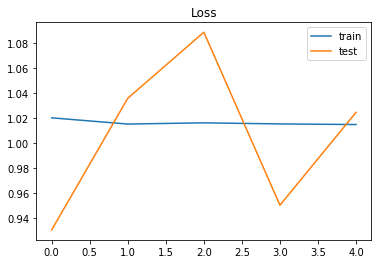

In [139]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

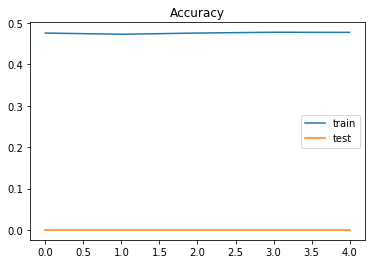

In [140]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [141]:
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,  lower=True)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
#print (len(word_index))
print('Found %s unique tokens.' % len(word_index))

Found 5786 unique tokens.


In [142]:
from keras.preprocessing.sequence import pad_sequences

X_sequence_train = tokenizer.texts_to_sequences(X_train)
X_sequence_test = tokenizer.texts_to_sequences(X_test)

X_train_pading = pad_sequences(X_sequence_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pading= pad_sequences(X_sequence_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X_train_pading.shape)
print('Shape of data tensor:', X_test_pading.shape)

Shape of data tensor: (2180, 500)
Shape of data tensor: (545, 500)


In [143]:
encoder= LabelBinarizer()
encoder.fit(Y_train)
Y_sequence_train= encoder.transform(Y_train)
print('Shape of label tensor:', Y_sequence_train.shape)
Y_sequence_test= encoder.transform(Y_test)
print('Shape of label tensor:', Y_sequence_test.shape)

#Y_sequence_train = pd.get_dummies(Y_train)
#print('Shape of label tensor:', Y_sequence_train.shape)
#Y_sequence_test = pd.get_dummies(Y_test)
#print('Shape of label tensor:', Y_sequence_test.shape)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

Shape of label tensor: (2180, 3)
Shape of label tensor: (545, 3)


In [144]:
from imblearn.over_sampling import SMOTE
smote = SMOTE('minority')
X_sm_deep1, y_sm_deep1 = smote.fit_sample(X_train_pading, Y_sequence_train)
print(X_sm_deep1.shape, y_sm_deep1.shape)

(3415, 500) (3415, 3)


In [145]:
#LSTM TASK

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=500))
#model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 100)          5000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 303       
Total params: 5,080,703
Trainable params: 5,080,703
Non-trainable params: 0
_________________________________________________________________
None


In [146]:
from sklearn.utils import class_weight
epochs = 10
batch_size = 12
history = model.fit(X_sm_deep1, y_sm_deep1, epochs=epochs, batch_size=batch_size,validation_split=0.1)
# history = model.fit(X_sm_deep1, y_sm_deep1, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 3073 samples, validate on 342 samples
Epoch 1/10
3073/3073 [==============================] - 98s 32ms/step - loss: 1.0022 - acc: 0.4888 - val_loss: 1.0822 - val_acc: 0.1316
Epoch 2/10
3073/3073 [==============================] - 94s 31ms/step - loss: 0.8055 - acc: 0.6424 - val_loss: 0.9022 - val_acc: 0.4912
Epoch 3/10
3073/3073 [==============================] - 94s 30ms/step - loss: 0.5609 - acc: 0.7719 - val_loss: 0.8262 - val_acc: 0.6111
Epoch 4/10
3073/3073 [==============================] - 90s 29ms/step - loss: 0.4049 - acc: 0.8471 - val_loss: 0.9805 - val_acc: 0.5731
Epoch 5/10
3073/3073 [==============================] - 91s 30ms/step - loss: 0.3024 - acc: 0.8920 - val_loss: 1.1023 - val_acc: 0.5731
Epoch 6/10
3073/3073 [==============================] - 91s 30ms/step - loss: 0.2283 - acc: 0.9216 - val_loss: 1.1852 - val_acc: 0.6170
Epoch 7/10
3073/3073 [==============================] - 92s 30ms/step - loss: 0.1780 - acc: 0.9352 - val_loss: 1.1484 - val_acc: 0.6696
E

In [148]:
pred = model.predict(X_test_pading, batch_size=12, verbose=1)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(Y_sequence_test, axis=1), predicted)
print(report)


545/545 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

           0       0.76      0.55      0.64       370
           1       0.50      0.39      0.44       130
           2       0.10      0.38      0.16        45

   micro avg       0.50      0.50      0.50       545
   macro avg       0.45      0.44      0.41       545
weighted avg       0.65      0.50      0.55       545



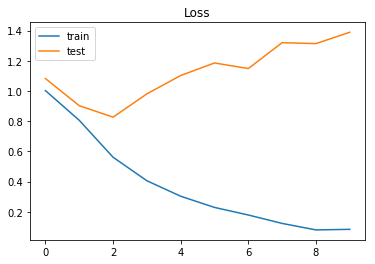

In [149]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

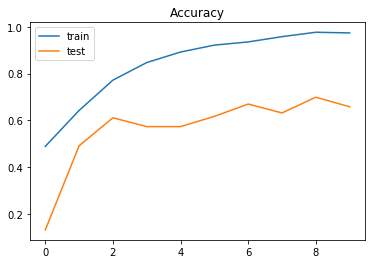

In [150]:

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [298]:
#Bidirectional LSTM

macronum=sorted(set(data['Rationale_Type']))
print(macronum)
#macro_to_id = dict((note, number) for number, note in enumerate(macronum))

#def fun(i):
    #return macro_to_id[i]

#data['Rationale_Type']=data['Rationale_Type'].apply(fun)
#print(df['Rationale_Type'])

[0, 1, 2]


In [299]:
rationale_labels = []
for idx in data['Rationale_Type']:
    rationale_labels.append(idx)

In [300]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(user_comments)
sequences_bidirectional = tokenizer.texts_to_sequences(user_comments)
#print(X_sequences_train_bidirectional)
#X_sequences_test_bidirectional = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

final_data = pad_sequences(sequences_bidirectional, maxlen=MAX_SEQUENCE_LENGTH)
#X_test_pad_bidirectional = pad_sequences(X_sequences_test_bidirectional, maxlen=MAX_SEQUENCE_LENGTH)


#print(X_test_pad_bidirectional.shape)
rationale_labels=to_categorical(np.asarray(rationale_labels))
print(final_data.shape, rationale_labels.shape)
#print(word_index)



Number of Unique Tokens 6531
(2725, 1000) (2725, 3)


In [301]:
X_train_bidirectional, X_test_bidirectional, Y_train_bidirectional, Y_test_bidirectional = train_test_split(final_data,rationale_labels, test_size = 0.20, random_state = 42)
print(X_train_bidirectional.shape, X_test_bidirectional.shape, Y_train_bidirectional.shape, Y_test_bidirectional.shape)

(2180, 1000) (545, 1000) (2180, 3) (545, 3)


In [304]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.1

In [303]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [305]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [306]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [307]:
from imblearn.over_sampling import SMOTE
smote = SMOTE('minority')
X_sm_bidirectional, y_sm_bidirectional = smote.fit_sample(X_train_bidirectional, Y_train_bidirectional)
print(X_sm_bidirectional.shape, y_sm_bidirectional.shape)

(3415, 1000) (3415, 3)


In [308]:
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

In [309]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(len(macronum), activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 1000, 100)         653200    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_38 (Dense)             (None, 3)                 603       
Total params: 814,603
Trainable params: 814,603
Non-trainable params: 0
_________________________________________________________________


In [310]:
from sklearn.utils import class_weight
class_weight= class_weight.compute_class_weight('balanced', np.unique(rationale_type),rationale_type)
print(class_weight)

[0.49473493 1.48178358 3.2910628 ]


In [311]:


cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(X_sm_bidirectional, y_sm_bidirectional, validation_data=(X_test_bidirectional, Y_test_bidirectional),epochs=15, batch_size=12,class_weight=class_weight )

Train on 3415 samples, validate on 545 samples
Epoch 1/15
3415/3415 [==============================] - 249s 73ms/step - loss: 0.9641 - acc: 0.5236 - val_loss: 1.0930 - val_acc: 0.4661
Epoch 2/15
3415/3415 [==============================] - 244s 71ms/step - loss: 0.8215 - acc: 0.6436 - val_loss: 1.2433 - val_acc: 0.4037
Epoch 3/15
3415/3415 [==============================] - 244s 71ms/step - loss: 0.7228 - acc: 0.6899 - val_loss: 0.8027 - val_acc: 0.6514
Epoch 4/15
3415/3415 [==============================] - 244s 71ms/step - loss: 0.6244 - acc: 0.7406 - val_loss: 0.8852 - val_acc: 0.6147
Epoch 5/15
3415/3415 [==============================] - 243s 71ms/step - loss: 0.5255 - acc: 0.7886 - val_loss: 1.0052 - val_acc: 0.5780
Epoch 6/15
3415/3415 [==============================] - 243s 71ms/step - loss: 0.4328 - acc: 0.8228 - val_loss: 1.1049 - val_acc: 0.5670
Epoch 7/15
3415/3415 [==============================] - 243s 71ms/step - loss: 0.3523 - acc: 0.8615 - val_loss: 1.1205 - val_acc: 0

In [313]:
pred = model.predict(X_test_bidirectional, batch_size=12, verbose=1)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(Y_test_bidirectional, axis=1), predicted)
print(report)

545/545 [==============================] - 7s 13ms/step
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       370
           1       0.49      0.35      0.41       130
           2       0.17      0.40      0.24        45

   micro avg       0.61      0.61      0.61       545
   macro avg       0.48      0.49      0.46       545
weighted avg       0.65      0.61      0.62       545



C:\Users\Ali\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



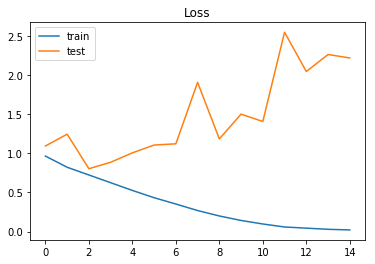

In [314]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

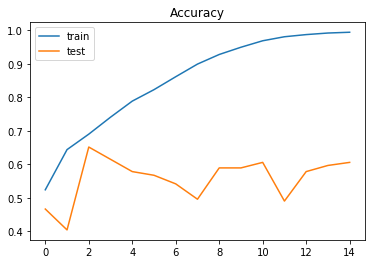

In [315]:

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [374]:
#convotional network
rationale_labels_convolutional = []
for idx in data['Rationale_Type']:
    rationale_labels_convolutional.append(idx)

In [375]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(user_comments)
sequences_convolutional = tokenizer.texts_to_sequences(user_comments)
#print(X_sequences_train_bidirectional)
#X_sequences_test_bidirectional = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

final_data_convolutional = pad_sequences(sequences_convolutional, maxlen=MAX_SEQUENCE_LENGTH)
#X_test_pad_bidirectional = pad_sequences(X_sequences_test_bidirectional, maxlen=MAX_SEQUENCE_LENGTH)


#print(X_test_pad_bidirectional.shape)
rationale_labels_convolutional=to_categorical(np.asarray(rationale_labels_convolutional))
print(final_data_convolutional.shape, rationale_labels_convolutional.shape)

Number of Unique Tokens 6531
(2725, 1000) (2725, 3)


In [376]:
X_train_convolutional, X_test_convolutional, Y_train_convolutional, Y_test_convolutional = train_test_split(final_data_convolutional,rationale_labels_convolutional, test_size = 0.20, random_state = 42)
print(X_train_convolutional.shape, X_test_convolutional.shape, Y_train_convolutional.shape, Y_test_convolutional.shape)

(2180, 1000) (545, 1000) (2180, 3) (545, 3)


In [377]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.1

In [378]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [379]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [380]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [381]:
from imblearn.over_sampling import SMOTE
smote = SMOTE('minority')
X_sm_convolutional, y_sm_convolutional = smote.fit_sample(X_train_convolutional, Y_train_convolutional)
print(X_sm_convolutional.shape, y_sm_convolutional.shape)

(3415, 1000) (3415, 3)


In [382]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_25 (Embedding)     (None, 1000, 100)         653200    
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 199, 128)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 39, 128)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 

In [383]:
from sklearn.utils import class_weight

class_weight= class_weight.compute_class_weight('balanced', np.unique(rationale_type),rationale_type)
print(class_weight)

[0.49473493 1.48178358 3.2910628 ]


In [384]:
epochs=5
batch_size=12
history = model.fit(X_sm_convolutional, y_sm_convolutional, epochs=epochs, batch_size=batch_size,class_weight=class_weight, validation_split=0.1)
score= model.evaluate(X_test_convolutional, Y_test_convolutional, batch_size=batch_size, verbose=1)
print("Test Loss: {}". format(score[0]))
print("Test Accuracy: {}". format(score[1]))
#history=model.fit(X_sm_convolutional, y_sm_convolutional, validation_data=(X_test_convolutional, Y_test_convolutional),epochs=5, batch_size=12)


Train on 3073 samples, validate on 342 samples
Epoch 1/5
3073/3073 [==============================] - 43s 14ms/step - loss: 1.0021 - acc: 0.5288 - val_loss: 0.3710 - val_acc: 0.9269
Epoch 2/5
3073/3073 [==============================] - 39s 13ms/step - loss: 0.8286 - acc: 0.6515 - val_loss: 0.7678 - val_acc: 0.5936
Epoch 3/5
3073/3073 [==============================] - 39s 13ms/step - loss: 0.6924 - acc: 0.7123 - val_loss: 0.2830 - val_acc: 0.8713
Epoch 4/5
3073/3073 [==============================] - 39s 13ms/step - loss: 0.5611 - acc: 0.7722 - val_loss: 0.6204 - val_acc: 0.7251
Epoch 5/5
545/545 [==============================] - 3s 5ms/step
Test Loss: 1.2661193064593395
Test Accuracy: 0.5045871523542141


In [385]:
pred = model.predict(X_test_convolutional, batch_size=12, verbose=1)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(Y_test_convolutional, axis=1), predicted)
print(report)

545/545 [==============================] - 4s 8ms/step
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       370
           1       0.48      0.29      0.36       130
           2       0.14      0.58      0.23        45

   micro avg       0.50      0.50      0.50       545
   macro avg       0.46      0.48      0.41       545
weighted avg       0.64      0.50      0.55       545



C:\Users\Ali\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



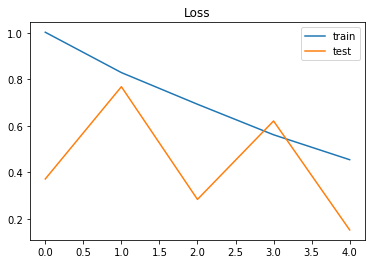

In [386]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

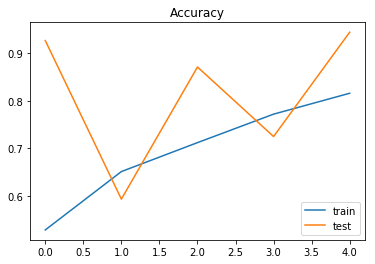

In [387]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();